In [1]:
# use 2 color inputs and 2 outputs: 1 for left and 1 for right


import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF2C2O, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch

In [2]:


x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF2C2O.generate_checker_data(10000)


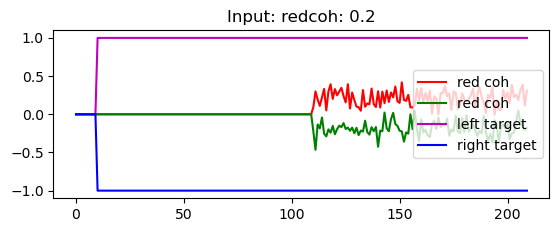

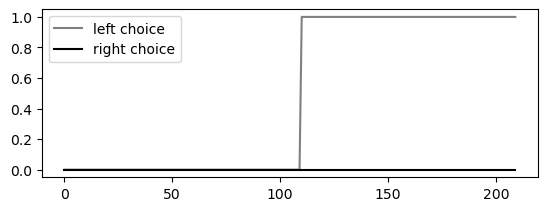

In [3]:
n = 34

plt.figure()
plt.subplot(211)
# plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'red coh', color = 'r')
plt.plot(x_val[n,:,1], label = 'red coh', color = 'g')

plt.plot(x_val[n,:,2], 'm', label = 'left target')
plt.plot(x_val[n,:,3], 'b', label = 'right target')
plt.title('Input: redcoh: ' + str(cohAll_val[n]))
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(y_val[n,:,0], label = 'left choice', color = 'gray')
plt.plot(y_val[n,:,1], label = 'right choice', color = 'black')
plt.legend()
plt.show()



tensor(0.)


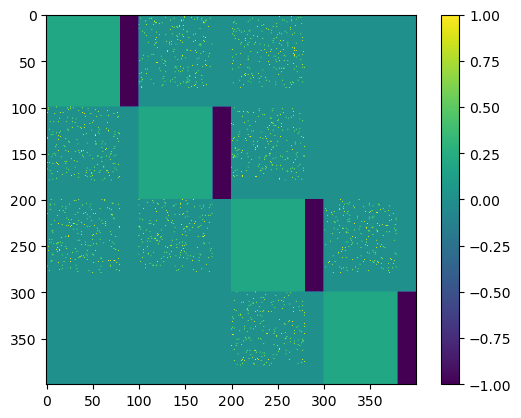

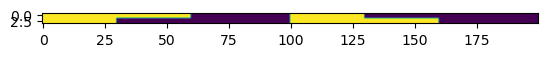

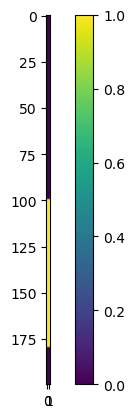

In [4]:
n_neurons = 400
n_inputs = 4
n_outputs = 2

# local connections are continuous 
def create_local_conn(Inum, ratio, n_neurons):

    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = -1
    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec



def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
    
    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec




def create_area_conn1(ratio, rows, cols): 
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1


    return matrix



mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.zeros(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)


mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


connStrength = 0.0314

# area2 to 1 feedback
mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)


# area1 to 2 feedforward
mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)

# area 1 to 3 feedforward 
mask_rec[200:300,0:100] = create_area_conn(20,connStrength,100)


# area3to 2 feedback
mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)


# area2 to 3 feedforward
mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)
# mask_rec[200:300,100:140] = 0



# area3 to 4 feedback
mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)


# area3 to 4 feedforward
mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)


# area3 to 1 feedback
mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)




# mask_in[:2,:40] = 1
# mask_in[2:,:10] = 1


# mask_in[:2,100:110] = 1
# mask_in[2:,100:140] = 1


mask_in[:2,:60] = 1
mask_in[2:,:30] = 1


mask_in[:2,100:130] = 1
mask_in[2:,100:160] = 1


mask_out[:300,:] = 0
mask_out[380:,:] = 0




wi_mask = mask_in
wo_mask = mask_out	



wrec_mask = mask_rec.t()



print(torch.sum(wrec_mask))

plt.imshow(mask_rec, cmap = 'viridis')
plt.colorbar()
plt.show()

plt.imshow(wi_mask[:,:200])
plt.show()
plt.imshow(wo_mask[200:])
plt.colorbar()
plt.show()


In [5]:
winit = torch.nn.Parameter(torch.normal(mean=0, std=1/sqrt(400), size=(400, 400)))

param = torch.nn.Parameter(torch.randn(400, 400) * (1/sqrt(400)))


winit = abs(winit)*wrec_mask

print(torch.sum(winit))


tensor(-0.0704, grad_fn=<SumBackward0>)


In [6]:
noise_std = 1e-2
alpha = .1
lr = 1e-3





net = FullRankRNN(n_inputs, n_neurons, n_outputs, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True,
                  wrec_mask = wrec_mask, wi_mask = wi_mask, wo_mask = wo_mask, 
                 b_init = None, add_biases = False)


# after trained, recurrent connectivity are all zero
# after trained, bias term will make test accuracy very low
net.non_linearity = torch.relu
net.out_non_linearity = torch.relu

# net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=30, lr=lr, batch_size=100, 
      mask_gradients = False, keep_best=True, cuda=True, early_stop=0.1, clip_gradient = 1)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TF2C2O.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

tensor(14.5014)
Training...
initial loss: 0.238
epoch 0:  loss=0.166  (took 14.97 s) *
epoch 1:  loss=0.136  (took 14.94 s) *
epoch 2:  loss=0.134  (took 14.54 s) *
epoch 3:  loss=0.133  (took 14.33 s) *
epoch 4:  loss=0.131  (took 14.46 s) *
epoch 5:  loss=0.130  (took 14.13 s) *
epoch 6:  loss=0.129  (took 14.44 s) *
epoch 7:  loss=0.128  (took 14.47 s) *
epoch 8:  loss=0.127  (took 14.40 s) *
epoch 9:  loss=0.127  (took 14.21 s) *
epoch 10:  loss=0.126  (took 14.33 s) *
epoch 11:  loss=0.126  (took 13.85 s) *
epoch 12:  loss=0.126  (took 13.74 s) *
epoch 13:  loss=0.125  (took 13.84 s) *
epoch 14:  loss=0.125  (took 13.88 s) *
epoch 15:  loss=0.125  (took 13.68 s) *
epoch 16:  loss=0.124  (took 14.45 s) *
epoch 17:  loss=0.122  (took 14.46 s) *
epoch 18:  loss=0.096  (took 14.77 s) *
loss=0.093, acc=0.953


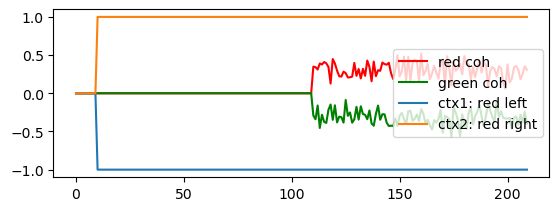

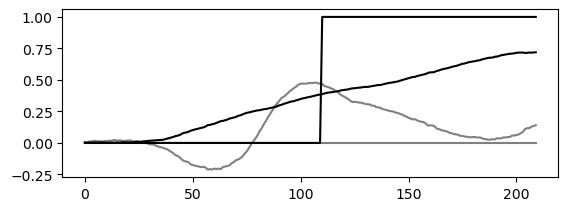

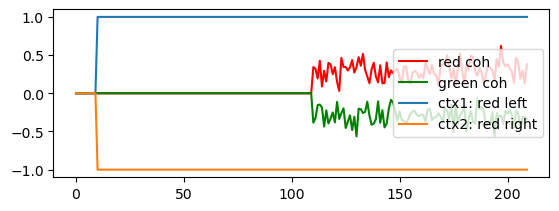

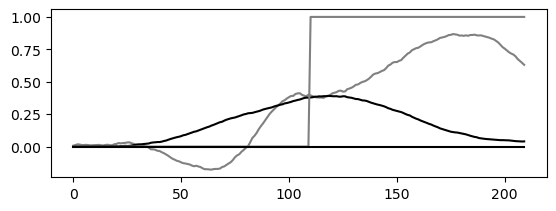

In [7]:
out = out.cpu()
aa = out.detach().numpy()

y_val = y_val.cpu()
x_val = x_val.cpu()


for n in range(40, 42):
    plt.figure()

    plt.subplot(211)
    plt.plot(x_val[n,:,0], label = 'red coh', color = 'r')
    plt.plot(x_val[n,:,1], label = 'green coh', color = 'g')

    plt.plot(x_val[n,:,2], label = 'ctx1: red left')
    plt.plot(x_val[n,:,3], label = 'ctx2: red right')

    plt.legend()
    plt.show()

    plt.subplot(212)
    plt.plot(aa[n,:,0], label = 'output L', color = 'gray')
    # plt.plot(y_val[n,:,0], label = 'y L', color = 'gray')
    plt.plot(aa[n,:,1], label = 'output R', color = 'black')
    # plt.plot(y_val[n,:,1], label = 'y R', color = 'black')
    plt.plot(y_val[n,:,0], color = 'gray')
    plt.plot(y_val[n,:,1], color = 'black')


# plot psth

In [9]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == 0, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == 0, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

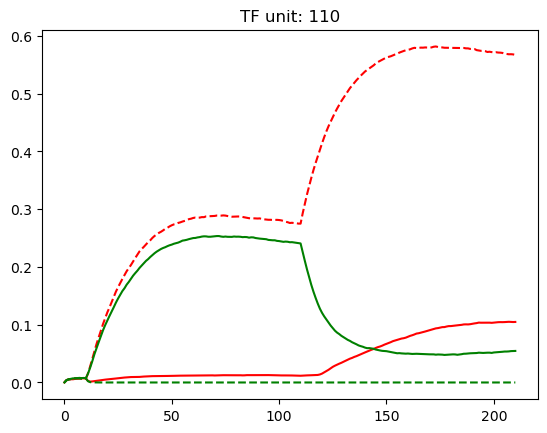

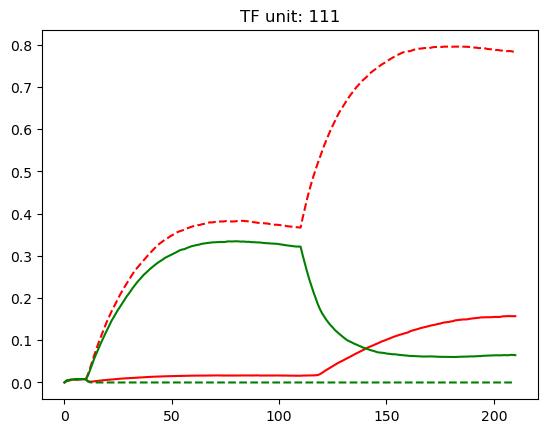

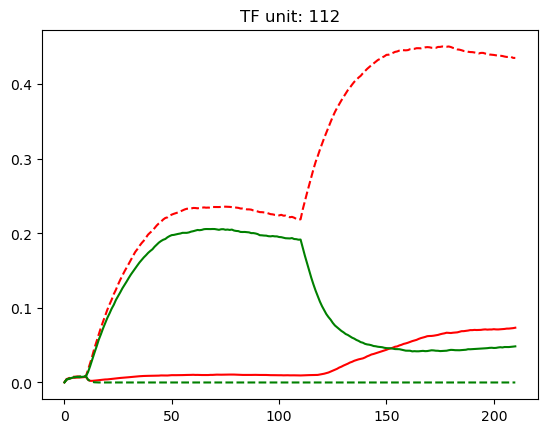

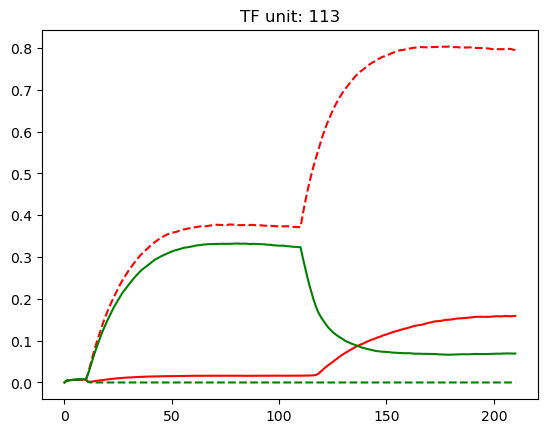

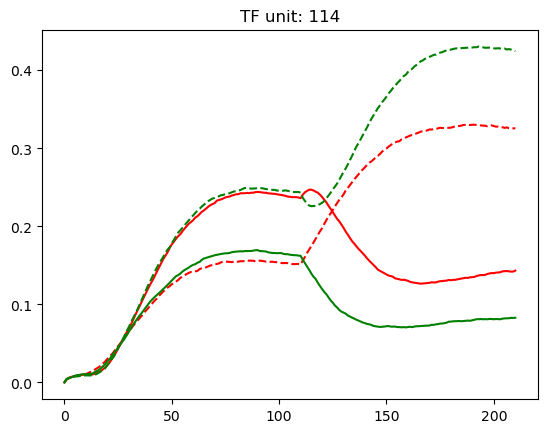

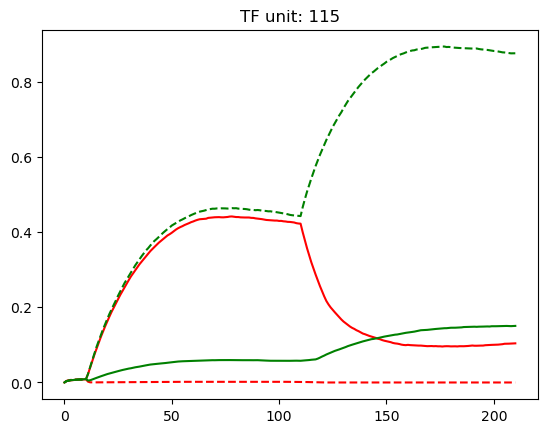

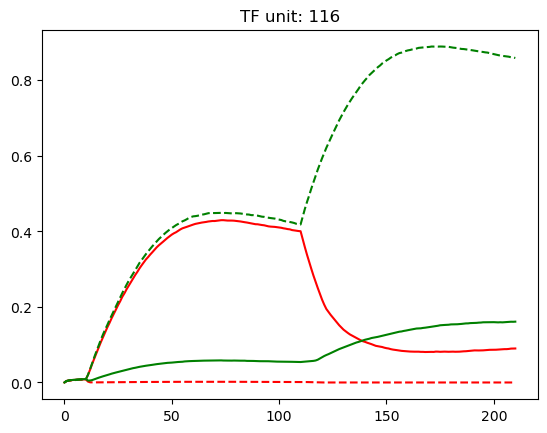

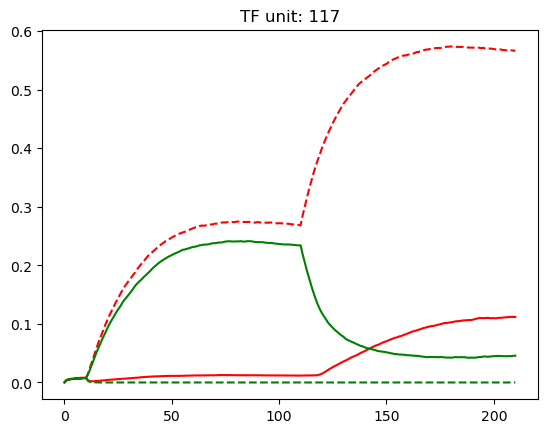

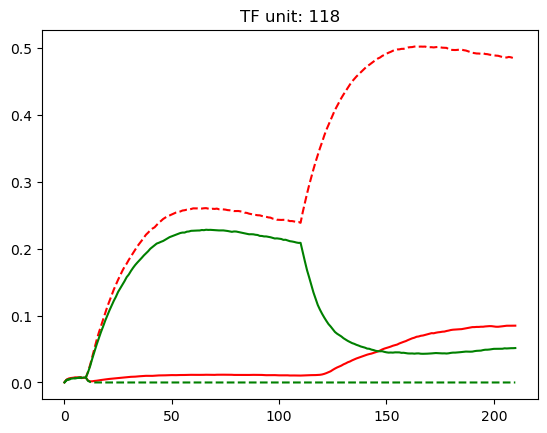

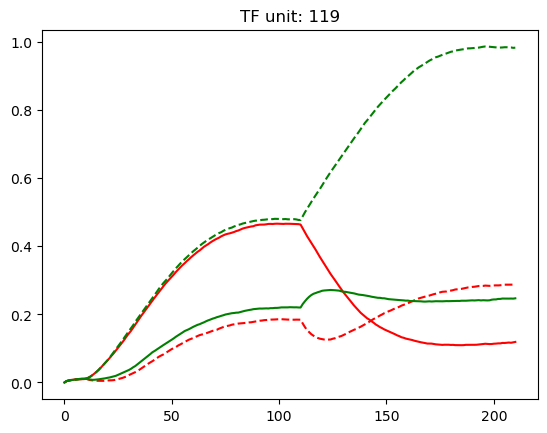

In [16]:
for n in range(110, 120):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

In [38]:
for n in range(70, 80):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

NameError: name 'tfRL' is not defined

<Figure size 640x480 with 0 Axes>

tensor(-52.7727)


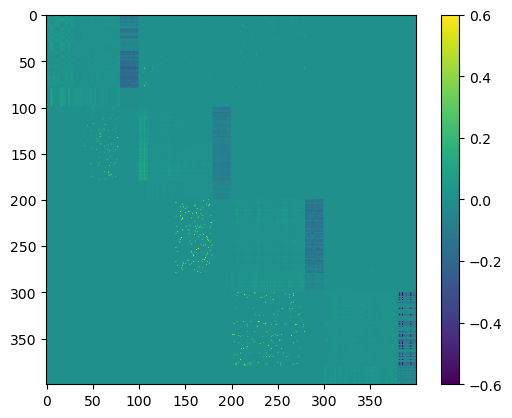

In [47]:

# load a full-rank RNN
net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/4AreasA5_0.pt', map_location='cpu'))


a = net.wrec_mask.cpu()
a = a.detach().numpy()

b = net.wrec.cpu()
b = b.detach().numpy()
c = np.abs(b)*a
plt.imshow(np.transpose(c), vmin=-0.6, vmax=0.6)
plt.colorbar()

tensor(-24.9331)


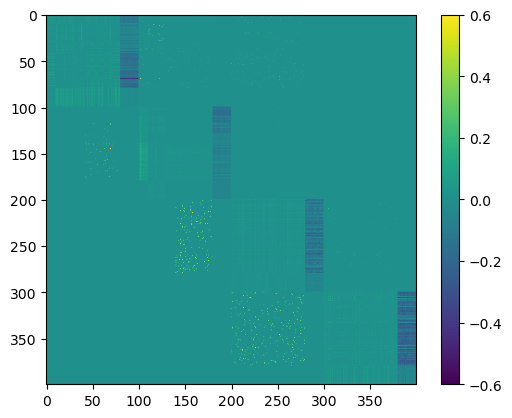

In [49]:
# load a full-rank RNN
net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/4AreasA5_1.pt', map_location='cpu'))


a = net.wrec_mask.cpu()
a = a.detach().numpy()

b = net.wrec.cpu()
b = b.detach().numpy()
c = np.abs(b)*a
plt.imshow(np.transpose(c), vmin=-0.6, vmax=0.6)
plt.colorbar()

# plot the connectivity matrix


In [23]:
wrec = net.w_rec_eff.cpu()
wi = net.w_in_eff.cpu()
wo = net.w_out_eff.cpu()

a = wrec.detach().numpy()
plt.imshow(np.transpose(a))
plt.colorbar()
plt.set_cmap('viridis')
plt.clim(-0.1, 0.1)
plt.show()

b = wi.detach().numpy()
plt.imshow(b[:,:200])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c[300:])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()


AttributeError: 'FullRankRNN' object has no attribute 'w_rec_eff'

In [25]:
# save the model
# torch.save(net.state_dict(), f'../models/4Areas3to1.pt')

In [50]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

In [51]:
a = np.mean(tfRL,axis = 0)
b = np.mean(tfRR,axis = 0)
c = np.mean(tfGL,axis = 0)
d = np.mean(tfGR,axis = 0)

psth = np.concatenate((a,b,c,d), axis=0) # error!
psth.shape

(844, 400)

In [52]:
# # low rank RNN PCA 

# def areaPCA(trajLow):
#     TOn = 10
#     COn = 100
    
#     pca = plot.pca_cumvar(trajLow, n_components=10)
#     plt.ylim(0, 1.02)
#     plt.axhline(1, ls='--', c='gray')
#     plt.show()
    
#     labels = ['RL', 'RR', 'GL', 'GR']
#     colors = ['red', 'red', 'green', 'green']
#     lineStyle = ['-', '--', '-', '--']
    
#     ax1 = pca.components_[0]
#     ax2 = pca.components_[1]
#     ax3 = pca.components_[2]
#     ax4 = pca.components_[3]
    
#     k1 = trajLow @ ax1
#     k2 = trajLow @ ax2
#     k3 = trajLow @ ax3
#     k4 = trajLow @ ax4
    
#     plt.figure()
#     for i in range(4):
#     #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
#         plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#     #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
#         plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#         plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#         plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
#     plt.show()
    
#     # 3D pca plot
#     from mpl_toolkits.mplot3d import Axes3D
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     for i in range(4):
#         plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
#         ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
#                 marker='.', s=400)
#         ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
#                 marker='.', s=400)
#     ax.axis('equal')

# # area 1:
# areaPCA(trajLow[:,:,200:300])
# # area 2:
# # areaPCA(trajLow[:,:,100:200])
# # area 3:
# # areaPCA(trajLow[:,:,200:])

In [54]:
area = np.arange(0,400)

dim = trajLow.shape
firingRatesAverage = np.zeros((400,2,2,dim[1]))

firingRatesAverage[:,0,0,:] = (trajLow[0,:,area])
firingRatesAverage[:,0,1,:] = (trajLow[1,:,area])
firingRatesAverage[:,1,0,:] = (trajLow[2,:,area])
firingRatesAverage[:,1,1,:] = (trajLow[3,:,area])


In [55]:
firingRatesAverage.shape

(400, 2, 2, 211)

In [56]:
from scipy.io import savemat
mdic = {"firingRatesAverage": firingRatesAverage}
savemat("../fr/jul29.mat", mdic)


In [31]:
firingRatesAverage.shape

(400, 2, 2, 211)